# Importation de toutes les données pour le projet
Ce fichier permet de préseneter toutes les méthodes d'importation des données. On commencera par expliquer l'importation des données INSEE (carreaux de 1km), les données d'Île de France Mobilité (*IDFM*) sur les stations puis sur les validations.

Toute la documentation relative aux données aux données que nous utilisons est disponible dans le *wiki* de notre *GitHub*.

Ces scripts sont ensuite intégrés dans des fichiers *.py* pour utiliser des fonction qui permettent d'importer directement les données. Une partie de ce Note Book est également consacré à la création de fond de carte avec *Cartiflette*.

## Packages

In [1]:
import geopandas as gpd
import pandas as pd
import requests
from io import BytesIO, StringIO
from zipfile import ZipFile
import tempfile
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point
from IPython.utils import io

Les commandes suivantes permettent de faire des cartes avec cartiflette.

In [2]:
with io.capture_output() as captured:
    !pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
    !pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [3]:
with io.capture_output() as captured:
    !pip install pandas fiona shapely pyproj rtree
    !pip install geopandas
    !pip install topojson

In [4]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import cartiflette.s3 as s3

## Données de l'INSEE
Le fichier avec les carreaux de 1km de l'Insee est très volumineux : afin de pouvoir le télécharger un traitement a été fait sur QGIS pour extraire un "sous-fichier" qui ne contient que les lignes des carreaux situés en Île de France.

Ces données sont stockées sur un *Google Drive* sous forme d'un dossier ZIP qui contient tous les élements permettant de lire le fichier *.shp*.

Le code *donnees_INSEE.py* permet de créer une fonction qui reprend exactement ce *NoteBook* et permettra de télécharger les données de facon automatisées dans les autres parties de notre projet.

In [5]:
#accès aux données disponibles sur un Google Drive
url_zip="https://drive.google.com/uc?export=download&id=1U9HT438foGzW06JdtVC3_ByA17Qipyrd" 

response = requests.get(url_zip)

# Répertoire temporaire pour stocker les fichiers
with tempfile.TemporaryDirectory() as tmpdirname:
    with ZipFile(BytesIO(response.content)) as zipfile:
        # Extraire tous les fichiers dans le répertoire temporaire
        zipfile.extractall(tmpdirname)

        # Rechercher le fichier .shp dans le répertoire temporaire
        for file_name in os.listdir(tmpdirname):
            if file_name.endswith('.shp'):
                shp_path = os.path.join(tmpdirname, file_name)
                data = gpd.read_file(shp_path)  

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [6]:
data.head()

,idcar_1km,i_est_1km,lcog_geo,ind,men,men_pauv,men_1ind,men_5ind,men_prop,men_fmp,...,ind_25_39,ind_40_54,ind_55_64,ind_65_79,ind_80p,ind_inc,pre_IDF,select,expt,geometry
0,CRS3035RES1000mN2774000E3848000,0,8932889437,136.5,49.9,2.0,10.1,5.0,44.0,6.1,...,21.1,40.0,11.0,11.0,2.0,0.0,NaN,1,1,"POLYGON ((749984.489 6755406.883, 749892.891 6..."
1,CRS3035RES1000mN2775000E3842000,0,89382,708.0,325.1,25.0,105.0,15.0,240.9,38.0,...,105.9,145.1,98.0,140.1,36.9,0.0,NaN,1,1,"POLYGON ((743922.298 6755837.684, 743830.655 6..."
2,CRS3035RES1000mN2775000E3843000,0,8938289201,513.0,231.0,15.9,85.0,9.9,172.1,24.0,...,68.9,126.0,68.1,77.0,22.0,0.0,NaN,1,1,"POLYGON ((744917.401 6755931.740, 744825.763 6..."
3,CRS3035RES1000mN2775000E3844000,1,8920189382,5.0,1.9,0.0,0.3,0.0,1.6,0.1,...,1.0,1.0,0.5,0.9,0.2,0.0,NaN,1,1,"POLYGON ((745912.502 6756025.784, 745820.870 6..."
4,CRS3035RES1000mN2775000E3845000,1,89201,4.0,1.5,0.0,0.3,0.0,1.3,0.1,...,0.8,0.8,0.4,0.7,0.1,0.0,NaN,1,1,"POLYGON ((746907.601 6756119.816, 746815.976 6..."


In [7]:
data.shape

(16817, 35)

In [8]:
data.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Données d'Île de France Mobilités
### Stations
Les stations sont directement accessibles sur le sîte d'Île de France Mobilités avec un lien de téléchargement direct.

In [9]:
url="https://data.iledefrance-mobilites.fr/api/explore/v2.1/catalog/datasets/emplacement-des-gares-idf/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
stations=pd.read_csv(url, sep=";")
stations = gpd.GeoDataFrame(stations, geometry=[Point(xy) for xy in zip(stations.x, stations.y)])
stations.crs = "EPSG:2154"

Dans la table il y a la colonne *x* et la colonne *y* qui permettent d'accéder à la position des stations. On utilise ces colonnes pour créer des points avec des coordonnées géographiques que l'on projette dans le système Lambert 93 (même format que les carreaux Insee). On vérifie que la transformation des données géographiques est cohérante.

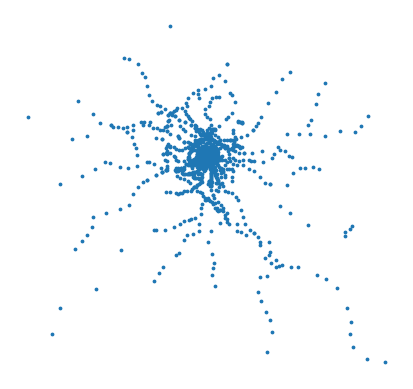

In [10]:
stations.plot(markersize=3).set_axis_off()

On réalise maintenant des cartes un peu plus jolie avec le package cartiflette et le fond de carte *open street map*.

In [11]:
with io.capture_output() as captured:
    shp_communes = s3.download_vectorfile_url_all(
        crs = 4326,
        values = ["75", "92", "93", "94", "77", "78", "91", "95"],
        borders="COMMUNE",
        vectorfile_format="topojson",
        filter_by="DEPARTEMENT",
        source="EXPRESS-COG-CARTO-TERRITOIRE",
        year=2022)

In [12]:
with io.capture_output() as captured:
    arrondissements = s3.download_vectorfile_url_all(
        crs = 4326,
        values = ["75"],
        borders="COMMUNE_ARRONDISSEMENT",
        vectorfile_format="topojson",
        filter_by="DEPARTEMENT",
        source="EXPRESS-COG-CARTO-TERRITOIRE",
        year=2022)

In [13]:
shp_communes = pd.concat(
  [
    shp_communes.loc[shp_communes['INSEE_DEP'] != "75"].to_crs(2154),
    arrondissements.to_crs(2154)
  ])

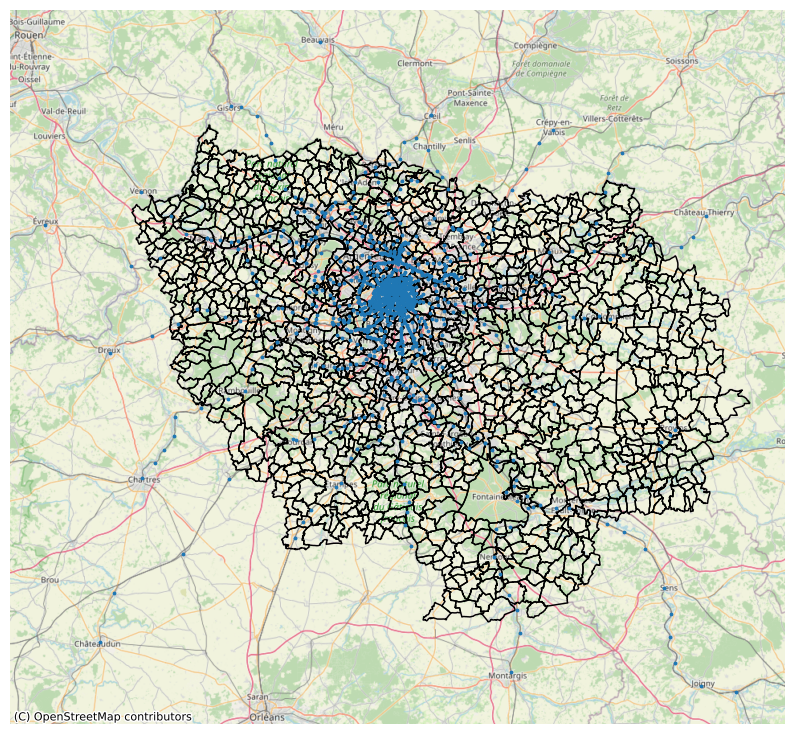

In [14]:
fig,ax = plt.subplots(figsize=(10, 10))
shp_communes.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
stations.to_crs(3857).plot(ax = ax, markersize=3)
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

### Données de validations
On présente ici la méthode générale pour importer toutes les données de validations (les données brutes sur tous les jours depuis 10 ans, ainsi que les profils horaires). 

Les données de 2023 sont accessibles en téléchargement direct depuis le site d'*IDFM*, cependant les données antérieures sont sauvegardées dans des fichiers *.zip*.

#### Données de 2023

In [15]:
print("début de l'importation du nombre de validations par jour S1 2023")
url = "https://data.iledefrance-mobilites.fr/api/explore/v2.1/catalog/datasets/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
data_validation_23 = pd.read_csv(url, sep=";")
print("fin de l'importation du nombre de validations par jour S1 2023")

print("début de l'importation profils horaires par jour type S1 2023")
url = "https://data.iledefrance-mobilites.fr/api/explore/v2.1/catalog/datasets/validations-reseau-ferre-profils-horaires-par-jour-type-1er-semestre/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
data_profils_horaires_23 = pd.read_csv(url, sep=";")
print("fin de l'importation profils horaires par jour type S1 2023")


début de l'importation du nombre de validations par jour S1 2023
fin de l'importation du nombre de validations par jour S1 2023
début de l'importation profils horaires par jour type S1 2023
fin de l'importation profils horaires par jour type S1 2023


In [16]:
data_validation_23.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,lda,CATEGORIE_TITRE,NB_VALD
0,2023-06-26,800,853,568,MONTSOULT,67000,NAVIGO,938
1,2023-06-26,800,853,568,MONTSOULT,67000,NON DEFINI,71
2,2023-06-26,800,853,595,NOINTEL MOURS,67227,NAVIGO JOUR,5
3,2023-06-26,800,853,63,BELLOY ST MA,67126,?,5
4,2023-06-26,800,853,637,PERSAN BEAUMONT,67292,?,147


In [17]:
data_profils_horaires_23.head()

,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,lda,CAT_JOUR,TRNC_HORR_60,pourc_validations
0,100,110,300,GALLIENI,71817,JOVS,23H-0H,0.82
1,100,110,300,GALLIENI,71817,SAHV,12H-13H,6.63
2,100,110,300,GALLIENI,71817,SAHV,16H-17H,7.49
3,100,110,300,GALLIENI,71817,SAHV,21H-22H,2.81
4,100,110,300,GALLIENI,71817,SAHV,3H-4H,0.00


#### Données de 2015 à 2022

Les données de validation du réseau ferré de 2015 à 2022 sont accessibles depuis le fichier suivant : chaque ligne correspond à une année qui donne accès au téléchargement des données. Il suffit donc de télécharger ces données une à une, et d'extraire les fichiers dont nous avons besoin depuis les dossiers ZIP que nous décompressons dans des dossiers temporaire.

In [18]:
url = "https://data.iledefrance-mobilites.fr/api/explore/v2.1/catalog/datasets/histo-validations-reseau-ferre/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
data_archives = pd.read_csv(url, sep=";")
data_archives.rename(columns=dict(zip(data_archives.columns, ["date", "lien"])), inplace=True)


In [19]:
data_archives.head()

,date,lien
0,2017,https://data.iledefrance-mobilites.fr/api/expl...
1,2019,https://data.iledefrance-mobilites.fr/api/expl...
2,2021,https://data.iledefrance-mobilites.fr/api/expl...
3,2022,https://data.iledefrance-mobilites.fr/api/expl...
4,2018,https://data.iledefrance-mobilites.fr/api/expl...


Attention : ce script prend plus de 5 minutes pour s'exécuter.

In [20]:
annees = [annee for annee in range(2015, 2023)]
table=["NB_S1", "PRO_S1", "NB_S2", "PRO_S2"]
validations_annees=pd.DataFrame()
profils_annees=pd.DataFrame()
for annee in annees:
    print(annee)
    url_zip = data_archives[data_archives['date'] == annee]['lien'].iloc[0]
    response = requests.get(url_zip)
    with ZipFile(BytesIO(response.content)) as zipfile:
        # On récupère la liste des noms de fichier dans le ZIP
        file_names = zipfile.namelist()
        i=0
        for file_name in file_names:
            if file_name.endswith('.zip'): print("fichier zip")
            else:                
                name=table[i]
                print(name)
                i+=1
                # Lecture du contenu du fichier
                with zipfile.open(file_name) as file:
                    if file_name.endswith('.csv') :
                        globals()[name] = pd.read_csv(file, sep=";")
                    elif annee==2022:
                        if name=="NB_S2" or name=="PRO_S2": globals()[name] = pd.read_csv(file, sep=";")
                        else: globals()[name] = pd.read_csv(file, sep='\t', header=0)
                    else:
                        globals()[name] = pd.read_csv(file, sep='\t', header=0)
    NB=pd.concat([NB_S1, NB_S2])
    NB['annee']=annee
    PRO=pd.concat([PRO_S1, PRO_S2])
    PRO['annee']=annee
    print(len(NB))
    print(len(PRO))
    validations_annees=pd.concat([validations_annees, NB])
    profils_annees=pd.concat([profils_annees, PRO])
    


2015
NB_S1
PRO_S1
NB_S2


/tmp/ipykernel_11041/881613741.py:22: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file, sep=";")


PRO_S2
1534736
156760
2016
NB_S1
PRO_S1
NB_S2


/tmp/ipykernel_11041/881613741.py:27: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file, sep='\t', header=0)


PRO_S2


/tmp/ipykernel_11041/881613741.py:27: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file, sep='\t', header=0)


1554133
164222
2017
NB_S1
PRO_S1
NB_S2


/tmp/ipykernel_11041/881613741.py:27: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file, sep='\t', header=0)


PRO_S2
1605968
165009
2018
NB_S1
PRO_S1
NB_S2


/tmp/ipykernel_11041/881613741.py:27: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file, sep='\t', header=0)


PRO_S2
1770685
164476
2019
NB_S1
PRO_S1
NB_S2


/tmp/ipykernel_11041/881613741.py:27: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file, sep='\t', header=0)


PRO_S2


/tmp/ipykernel_11041/881613741.py:27: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file, sep='\t', header=0)


1888305
165584
2020
NB_S1
PRO_S1
NB_S2


/tmp/ipykernel_11041/881613741.py:27: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file, sep='\t', header=0)


PRO_S2
fichier zip
fichier zip
fichier zip
fichier zip
fichier zip
1941505
161790
2021
NB_S1
PRO_S1
NB_S2
PRO_S2
2148300
163924
2022
NB_S1
PRO_S1
NB_S2


/tmp/ipykernel_11041/881613741.py:25: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  else: globals()[name] = pd.read_csv(file, sep='\t', header=0)


PRO_S2


/tmp/ipykernel_11041/881613741.py:24: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if name=="NB_S2" or name=="PRO_S2": globals()[name] = pd.read_csv(file, sep=";")


2194281
168514


In [21]:
validations_annees

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD,annee,lda
0,01/01/2015,100,110,1,PORTE MAILLOT,71379,AMETHYSTE,117,2015,NaN
1,01/01/2015,100,110,1,PORTE MAILLOT,71379,AUTRE TITRE,37,2015,NaN
2,01/01/2015,100,110,1,PORTE MAILLOT,71379,FGT,172,2015,NaN
3,01/01/2015,100,110,1,PORTE MAILLOT,71379,IMAGINE R,605,2015,NaN
4,01/01/2015,100,110,1,PORTE MAILLOT,71379,NAVIGO,2039,2015,NaN
...,...,...,...,...,...,...,...,...,...,...
1105942,31/12/2022,810,802,905,VILLEPINTE,NaN,IMAGINE R,212,2022,73547.0
1105943,31/12/2022,810,802,905,VILLEPINTE,NaN,NAVIGO,614,2022,73547.0
1105944,31/12/2022,810,802,905,VILLEPINTE,NaN,NAVIGO JOUR,6,2022,73547.0
1105945,31/12/2022,810,802,905,VILLEPINTE,NaN,NON DEFINI,6,2022,73547.0


In [22]:
profils_annees

,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CAT_JOUR,TRNC_HORR_60,pourc_validations,annee,lda
0,100,110,1,PORTE MAILLOT,71379,DIJFP,0H-1H,1.96,2015,NaN
1,100,110,1,PORTE MAILLOT,71379,DIJFP,10H-11H,4.01,2015,NaN
2,100,110,1,PORTE MAILLOT,71379,DIJFP,11H-12H,4.43,2015,NaN
3,100,110,1,PORTE MAILLOT,71379,DIJFP,12H-13H,5.36,2015,NaN
4,100,110,1,PORTE MAILLOT,71379,DIJFP,13H-14H,5.53,2015,NaN
...,...,...,...,...,...,...,...,...,...,...
85249,810,802,905,VILLEPINTE,NaN,SAVS,5H-6H,"4,25",2022,73547.0
85250,810,802,905,VILLEPINTE,NaN,SAVS,6H-7H,"7,22",2022,73547.0
85251,810,802,905,VILLEPINTE,NaN,SAVS,7H-8H,"6,79",2022,73547.0
85252,810,802,905,VILLEPINTE,NaN,SAVS,8H-9H,"6,39",2022,73547.0
